# LightGBM Model Tuning

In [103]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("/Users/efim/PycharmProjects/")
sys.path.append("/Users/efim/PycharmProjects/SimpleAlgoTrade/model")
from SimpleAlgoTrade.model import FeatureEngineering as fe
from SimpleAlgoTrade.model.utils import ic_metric
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.inspection import PartialDependenceDisplay
import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm
from typing import Dict
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.figsize'] = (15, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
SEED = 123456789
np.random.seed(SEED)

# Read Data

In [28]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


In [29]:
file_name = "price_execution_data_list"

def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

price_execution_data = read_data_files(file_name)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)


del price_execution_data

price_execution_data_df = price_execution_data_df.sort_index()

In [30]:
price_execution_data_df.head()

,symbol,price,delta_time
time,,,
1.660649e+09,BTCUSDT,24071.72,1.332418
1.660649e+09,BTCUSDT,24071.40,0.611654
1.660649e+09,BTCUSDT,24072.47,1.330175
1.660649e+09,BTCUSDT,24073.85,0.592218
1.660649e+09,BTCUSDT,24072.48,0.634877


# Feature Engineering

In [31]:
feature_shift_return_most_recent = make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(1),fe.CalcReturn())
#feature_shift_return_most_recent

#### Shift Returns

In [32]:
feature_shift_returns = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(i*13),fe.CalcReturn()) for i in range(1,11)))
# feature_shift_returns

#### MA

In [33]:
feature_ma = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcMa(i*13), fe.CalcReturn()) for i in range(1,11)))
# feature_ma

#### BB Low

In [34]:
feature_bb_low = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcBB(13*i,"low"), fe.CalcReturn()) for i in range(1,11)))
# feature_bb_low

#### BB High

In [35]:
feature_bb_high = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcBB(13*i,"high"), fe.CalcReturn()) for i in range(1,11)))
# feature_bb_high

#### Quantile 0.01

In [36]:
feature_quantile_001 = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcReturn(), fe.CalcQuantile(13*i,0.01)) for i in range(1,11)))
# feature_quantile_001

#### Quantile 0.99

In [37]:
feature_quantile_099 = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcReturn(), fe.CalcQuantile(13*i,0.99)) for i in range(1,11)))
# feature_quantile_099

#### Rolling Std

In [38]:
feature_std= fe.make_union(*(make_pipeline(fe.FeatureSelector('price'),fe.CalcReturn(), fe.CalcStd(13*i)) for i in range(1,11)))
# feature_std

#### RSI

In [39]:
feature_rsi = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'),fe.CalcRsi(13*i)) for i in range(1,11)))
# feature_rsi

#### PPO

In [40]:
feature_ppo = make_pipeline(fe.FeatureSelector('price'), fe.CalcPpo())
# feature_ppo

#### Macd

In [41]:
feature_macd = make_pipeline(fe.FeatureSelector('price'), fe.CalcMacd())
# feature_macd

#### Target

In [42]:
target = make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(-13),fe.CalcReturn())
# target

#### Aggregate all Features

In [43]:
feature_union = fe.make_union(feature_shift_return_most_recent,
                              feature_shift_returns,
                              feature_ma,
                              feature_bb_low,
                              feature_bb_high,
                              feature_quantile_001,
                              feature_quantile_099,
                              feature_std,
                              feature_rsi,
                              feature_ppo,
                              feature_macd,
                              target)                           

In [44]:
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=1)),
                                                      ('calcreturn',
                                                       CalcReturn())])),
                                     ('pandasfeatureunion-1',
                                      PandasFeatureUnion(transformer_list=[('pipeline-1',
                                                                            Pipeline(steps=[('featureselector',
                                                                                             FeatureSelector(feature_names='price')),
                                                                                            ('calc...
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcppo', CalcPpo())])),
                                     ('pipeline-3',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcmacd',
                                                       CalcMacd())])),
                                     ('pipeline-4',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-13)),
                                                      ('calcreturn',
                                                       CalcReturn())]))])

## Create Train-Test Data

In [45]:
data = feature_union.fit_transform(price_execution_data_df)

In [46]:
data = data.dropna()
train_size = 0.8
test_size = 1-train_size
data_size = data.shape[0]

data_train = data.iloc[:int(data_size*train_size)]
data_test = data.iloc[int(data_size*train_size):]

target_names = ["returns_forward_13"]
feature_names = data.columns[:-1]

X_train, y_train = data_train[feature_names], data_train[target_names]
X_test, y_test = data_test[feature_names], data_test[target_names]

In [47]:
X_train.shape

(15895, 83)

## Hyper Parameter Tuning

In [48]:
# Time Series Cross Validation
def time_series_cross_validation(X: pd.DataFrame,
                                 y: pd.DataFrame,
                                 init_train_size:int,
                                 val_cv:int,
                                 model: callable,
                                 params: Dict):
    """
    X - feature data
    y - target data
    init_train_size - initial train data size
    cv - cross validation size
    """
    scores = {"train_ic":[],
              "val_ic":[],
              "sample_size":[]}
    regressor = model(**params)
    for sample_size in range(init_train_size, X.shape[0], val_cv):
        X_train = X.iloc[:sample_size]
        y_train = y.iloc[:sample_size]
        X_val = X.iloc[sample_size:sample_size+val_cv]
        y_val = y.iloc[sample_size:sample_size+val_cv]
        regressor.fit(X_train,y_train)
        y_train_pred = regressor.predict(X_train)
        y_val_pred = regressor.predict(X_val)
        scores["train_ic"].append(ic_metric(y_train, y_train_pred))
        scores["val_ic"].append(ic_metric(y_val, y_val_pred))
        scores["sample_size"].append(sample_size)
        sample_size += val_cv
    return scores 

# Setup objective function
def objective(params):
    cv_config = params["cv_config"]
    X, y , init_train_size, val_cv, model = cv_config.get("X"), cv_config.get("y"), cv_config.get("init_train_size"), cv_config.get("val_cv"), cv_config.get("model")
    scores = time_series_cross_validation(X,
                                          y,
                                          init_train_size,
                                          val_cv,
                                          model,
                                          params["space"])  
    return -np.mean(scores["val_ic"])

In [63]:
# CV Config
cv_conig = {"X": X_train,
            "y": y_train,
            "init_train_size": 10000,
            "val_cv": 500,
            "model": lgb.LGBMRegressor}

# Uninformative Priors
space = {
    'learning_rate':    hp.uniform('learning_rate', 0.01, 1),
    'num_leaves':       scope.int(hp.uniform('num_leaves', 3, 20)),
    'max_depth':        scope.int(hp.uniform('max_depth', 1, 20)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1), #feature_fraction
    'num_iterations':   scope.int(hp.uniform('num_iterations',10, 200)),
    # 'reg_alpha':        hp.choice("reg_alpha", np.arange(0, 2, 0.1)), #L1 can shirnk most of the features to zero, which will produce straight line pred
    'reg_lambda':        hp.choice("reg_lambda", np.arange(0, 2, 0.1)), #L2
    'seed': SEED
        }

params = {"cv_config":cv_conig,
          "space": space}

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials,
            rstate=np.random.default_rng(SEED))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/trial, best loss: -0.023188496416100383]


#### Tuning Result Visualisation

In [64]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index

int_col_names = ["max_depth", "num_iterations","num_leaves"]
for col_name in int_col_names:
    trials_df[col_name] = trials_df[col_name].apply(lambda x: int(x))
trials_df["corr"] = trials_df["loss"].apply(lambda x: -x) # the hyperopt goal is to minimize -corr

#### Trials vs Objective Func

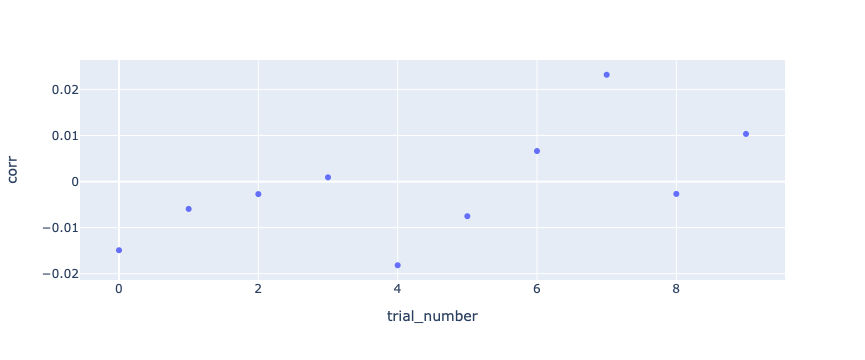

In [65]:
px.scatter(trials_df, x="trial_number", y="corr")

#### Contour plot
Features vs vs Objective Func

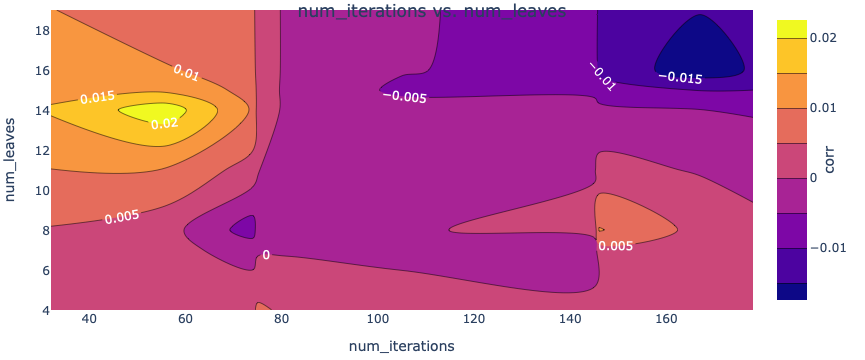

In [78]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["corr"],
        x=trials_df["num_iterations"],
        y=trials_df["num_leaves"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="corr", titleside="right",),
        hovertemplate="corr: %{z}<br>num_iterations: %{x}<br>num_leaves: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="num_leaves",
    title={
        "text": "num_iterations vs. num_leaves",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

## Re-Train the Model with best Params

In [86]:
def map_to_int(params):
    params_mapped = {}
    for key, val in params.items():
        if key in int_col_names:
            params_mapped[key] = int(val)
        else:
            params_mapped[key] = val
    return params_mapped
        
best_params = map_to_int(best)
print(best_params)

{'colsample_bytree': 0.7875512057359588, 'learning_rate': 0.18146036020003578, 'max_depth': 5, 'num_iterations': 56, 'num_leaves': 14, 'reg_lambda': 11, 'subsample': 0.9299723490982507}


In [88]:
scores =  time_series_cross_validation(X_train,
                                       y_train,
                                       cv_conig["init_train_size"],
                                       cv_conig["val_cv"],
                                       cv_conig["model"],
                                       best_params)

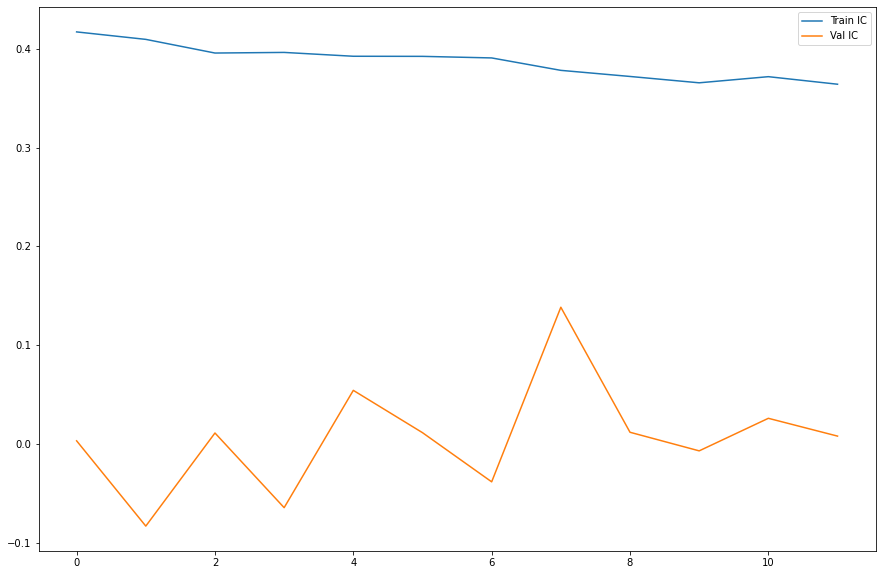

In [98]:
plt.plot(scores["train_ic"], label="Train IC")
plt.plot(scores["val_ic"], label="Val IC")
plt.legend()

In [92]:
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7875512057359588,
              learning_rate=0.18146036020003578, max_depth=5, num_iterations=56,
              num_leaves=14, reg_lambda=11, subsample=0.9299723490982507)

Text(0.5, 1.0, 'Top 30 feature imporance')

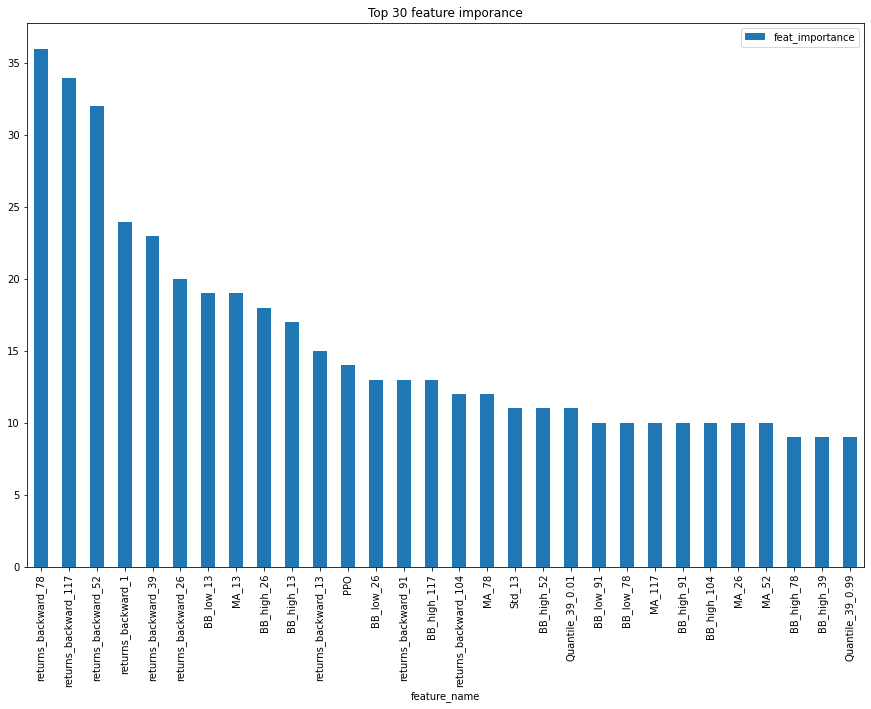

In [106]:
top = 30
df_feat = (
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

## Model Interperation Partial Depedency
Note: Correlation in between features are ignored

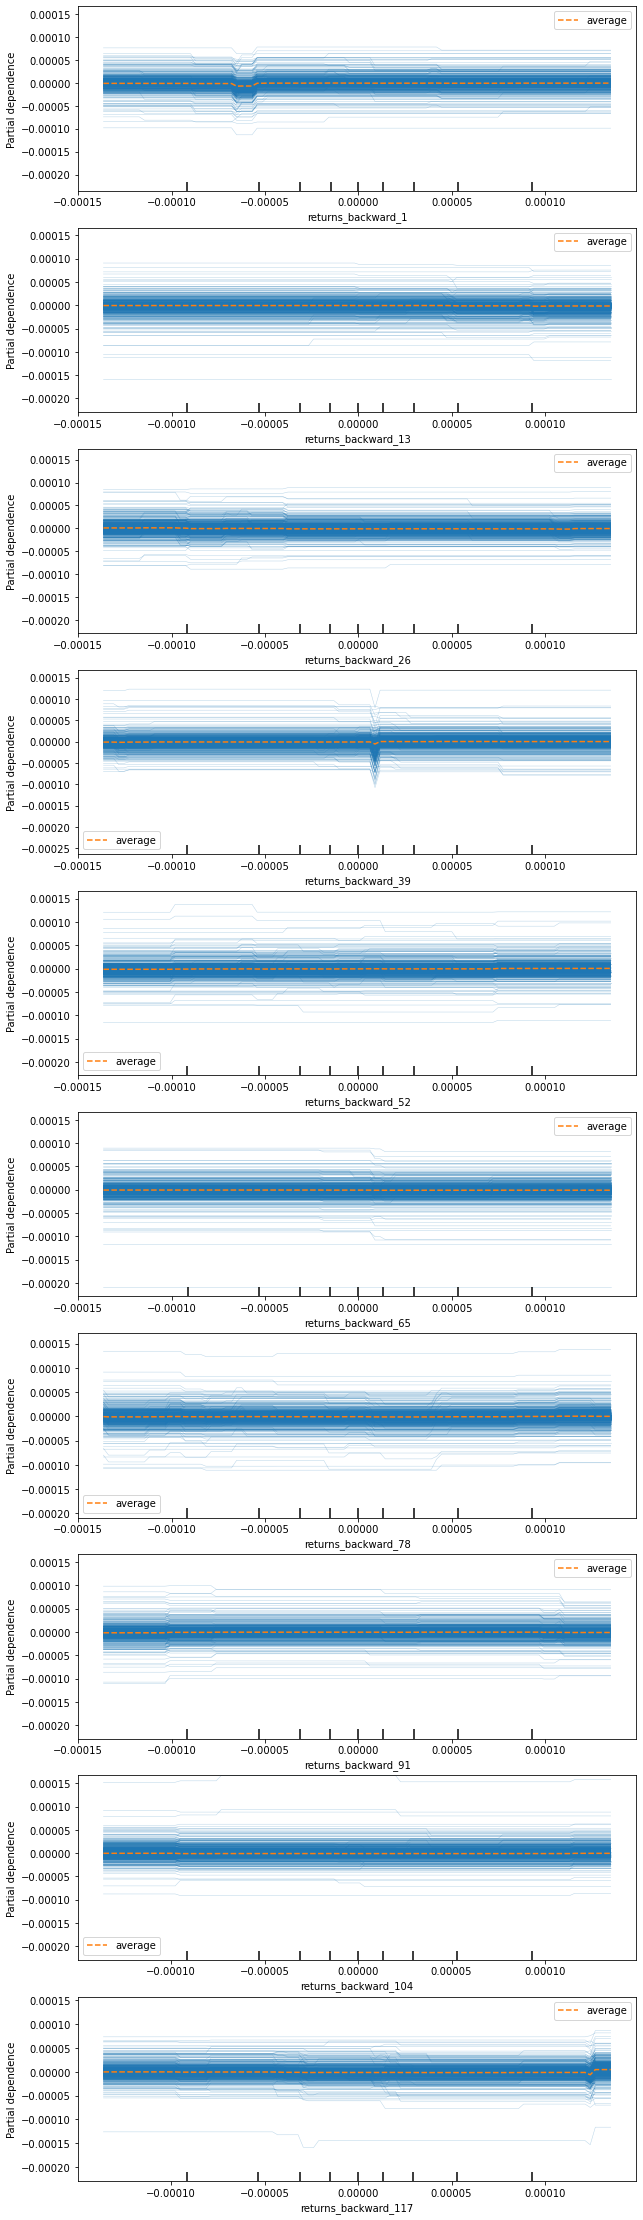

In [147]:
num_feat = 10
fig, ax = plt.subplots(10,1, figsize=(10, 40))
for i in range(num_feat):
    feat = df_feat["feature_name"][i]
    PartialDependenceDisplay.from_estimator(model, X_train, [feat], kind='both', ax=ax[i])

# Rubbish Bellow

In [52]:
trials_df.max_depth.apply(lambda x: int(x))

0     3
1     5
2     6
3     3
4     3
5    17
6     3
7    11
8    11
9    19
Name: max_depth, dtype: int64

In [53]:
trials.vals

{'colsample_bytree': [0.6685920132043679,
  0.6752149810002711,
  0.6172259721869584,
  0.9535756820355483,
  0.7953360761537305,
  0.6610380039669083,
  0.9998939905137243,
  0.948885080747539,
  0.6622226360102377,
  0.863653523798015],
 'learning_rate': [0.9177317369360567,
  0.3163264766382725,
  0.3240299118072625,
  0.3895430881252112,
  0.12266285543123533,
  0.9236355563149616,
  0.865127639404504,
  0.18941241096475878,
  0.24110456740294883,
  0.36776756607579614],
 'max_depth': [3.370115180564413,
  5.270712931078769,
  6.08971468745493,
  3.352971953548864,
  3.388705678383711,
  17.54046492408603,
  3.9477808727718564,
  11.299381228118662,
  11.76299792695092,
  19.001411642420553],
 'num_iterations': [159.98392156765814,
  60.84480403611507,
  24.333931710751422,
  164.76700598881266,
  89.792819770695,
  154.7442873426507,
  58.66795081167839,
  132.79749825469753,
  29.463040166523697,
  182.02184656065552],
 'num_leaves': [18.879529074185786,
  4.9192916531081465,
  7

In [54]:
plt.plot(scores["train_ic"])
plt.plot(scores["val_ic"])

NameError: name 'scores' is not defined

In [ ]:
plt.hist(scores["train_ic"])
plt.hist(scores["val_ic"])

In [ ]:
scores["val_ic"]

In [ ]:
scores["sample_size"]

In [ ]:
sample_size=100
val_cv=10
X_train_ = X_train.iloc[:sample_size]
y_train_ = y_train.iloc[:sample_size]
X_val = X_train.iloc[sample_size:sample_size+val_cv]
y_val = y_train.iloc[sample_size:sample_size+val_cv]
model = lgb.LGBMRegressor(**{"learning_rate":1, 'reg_alpha':0,'reg_lambda':0.1})

In [ ]:
model.fit(X_train_,y_train_)

In [ ]:
plt.plot(model.predict(X_val))
plt.plot(y_val.values)